In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

import datetime

import gc
import re
import os
from PIL import Image
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

stop = stopwords.words("english")

In [2]:
bulleting = os.listdir("cityofla\CityofLA\Job Bulletins")
additional_data = os.listdir("cityofla\CityofLA\Additional data")

In [3]:
#Regex compile

#Salary
#salary = re.compile("\$(\d+)")
salary = re.compile("\$(\d{4,8})")

#Opening date of the position
opendate=re.compile(r'(Open [D,d]ate:)(\s+)(\d+\-\d+-\d\d)')

#Requirements of the position
req_one = re.compile("REQUIREMENTS?(.*?)NOTES")

#Duties of the job
duty = re.compile("DUTIES?(.*)(REQ[A-Z])")

#End date of the application
end_date_reg = re.compile("(JANUARY|FEBRUARY|MARCH|APRIL|MAY|JUNE|JULY|AUGUST|SEPTEMBER|OCTOBER|NOVEMBER|DECEMBER)\s(\d{1,2}\s\d{4})")

#Extracts the selection process steps (Test/Essay/Interviw etc.)

#First part extracts the general area
test_area = re.compile("SELECTION(.*)(NO[A-Z])")
#Second part extracts keywords
tests = re.compile("Test|Essay|Interview|Questionnaire",re.IGNORECASE)

gc.collect()

51

In [4]:
def data_extractor(num_files,df_one,df_two):

    """
    Function for extracting data from text files and implementing them in a tabular format
    """

    for number in range(0, num_files):
        with open("cityofla/CityofLA/Job Bulletins/" + bulleting[number]) as text_data:

            #Remove tabs,new lines and commas with blank space
            data=text_data.read().replace('\t','')
            data= data.replace('\n',' ')
            data= data.replace(',','')

            #Extract file names

            try:
                job_name = re.search("^(.*?)\d{4}",bulleting[number]).group(1)

            except:
                job_name = np.nan

            #Salary extraction minimum and max offered
            sal=re.findall(salary,data)
            try:
                minimum_salary = min(sal)
                maximum_salary = max(sal)
            except:
                minimum_salary = np.nan
                maximum_salary = np.nan

            #Extracts the opening date of the position
            try:
                open_date=re.search(opendate,data).group(3)
            except:
                open_date = np.nan

            #Extracts a large portion of the sting describing the req for the job

            try:
                requi=re.search(req_one,data)[1]
            #Cleans part of the sting from Min Qual, Process and special char
                requi = re.sub("MI[A-Z]*\sQUAL[A-Z]{7,9}S?","",requi)
                requi = re.sub("PRO[A-Z]*","",requi)
                requi = re.sub(r"[-()\"#/@;:<>{}`+=~|]", "", requi)
            except:
                requi=np.nan     
            #Extracts a large portion desc the duties of the position
            try:
                duties=re.search(duty,data)[1]
            except:
                duties = np.nan
            #End date of the application
            try:
                endd=re.search(end_date_reg,data)[0]
            except:
                endd = np.nan
            #Extract area, find keywords,transform all of them to lowercase and drop duplicates
            try:
                string=re.findall(tests,re.search(test_area,data).group(0))
                string=list(pd.Series(string).str.lower())
                string=np.unique(string)
            except:
                string = np.nan

            df_one = df_one.append({"file_name":bulleting[number],"minimum_salary":minimum_salary,"maximum_salary":maximum_salary,"open_date":open_date,"requirements":requi,"job_duties":duties,"application_end_date":endd,"selection":string,"job_name":job_name}, ignore_index=True)

            df_two = df_two.append({"file_name":bulleting[number],"text_data":data},ignore_index=True)

    return df_one, df_two

In [5]:
df = pd.DataFrame()
df_file = pd.DataFrame()
df, df_file = data_extractor(len(bulleting),df,df_file)

gc.collect()

104

In [6]:
#Converting columns to datetime

df["application_end_date"] = pd.to_datetime(df["application_end_date"])
df["open_date"] = pd.to_datetime(df["open_date"])

gc.collect()

20

0

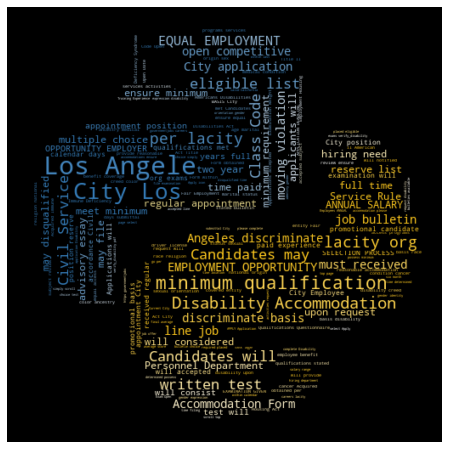

In [7]:
###### Wordcloud ######

all_jobs_text = " ".join(df_file["text_data"])
image_mask = np.array(Image.open("images\cityoflos14.jpg"))

word_cloud = WordCloud(background_color="black",max_words=5000,max_font_size=30, mask=image_mask, random_state=3)
word_cloud.generate(all_jobs_text)

image_colours = ImageColorGenerator(image_mask)


ax, fig = plt.subplots(figsize=(8,8))
plt.imshow(word_cloud.recolor(color_func = image_colours),interpolation="bilinear")

plt.axis("off")

gc.collect()

In [8]:
#df.dropna(subset=["open_date"],inplace=True)
df.set_index(df["open_date"], inplace=True)

#Set numeric types

df["maximum_salary"] = pd.to_numeric(df["maximum_salary"])
df["minimum_salary"] = pd.to_numeric(df["minimum_salary"])

gc.collect()

20

In [9]:
#Resample data

monthly_salaries = pd.DataFrame(df.resample("M").size(),columns=["count"])
monthly_salaries["max_mean"] = df["maximum_salary"].resample("M").mean()
monthly_salaries["min_mean"] = df["minimum_salary"].resample("M").mean()

gc.collect()

86

Text(2013-10-01, 158000, 'The movement of the average maximum salary over time from 2014 - 2019.')

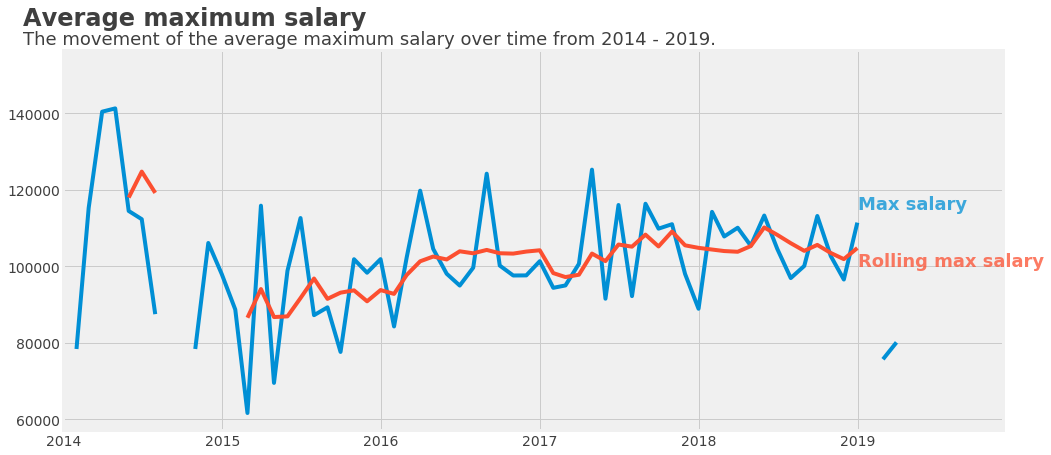

In [10]:
#Maximum salaries over time
ax, fig = plt.subplots(figsize=(15,7))

ax = plt.axes()
ax.set_xlim(left = datetime.date(2014, 1, 1), right = datetime.date(2019, 12, 1))

plt.plot(monthly_salaries["max_mean"])
plt.plot(monthly_salaries["max_mean"].rolling(window=5).mean())

plt.xticks(fontsize=14,alpha=0.75)
plt.yticks(fontsize=14,alpha=0.75)


ax.text(x=datetime.date(2019, 1, 1), y=115000,s="Max salary", weight="bold",fontsize="18",alpha=0.75,color="#008fd5")

ax.text(x=datetime.date(2019, 1, 1), y=100000,s="Rolling max salary", weight="bold",fontsize="18",alpha=0.75,color="#fc4f30")

#Title
ax.text(x=datetime.date(2013, 10, 1), y=163000,s="Average maximum salary", weight="bold",fontsize="24",alpha=0.75)
ax.text(x=datetime.date(2013, 10, 1), y=158000,s="The movement of the average maximum salary over time from 2014 - 2019.", fontsize="18",alpha=0.75)

gc.collect()

Text(2013-10-01, 135000, 'The movement of the average minimum salary over time from 2014 - 2019.')

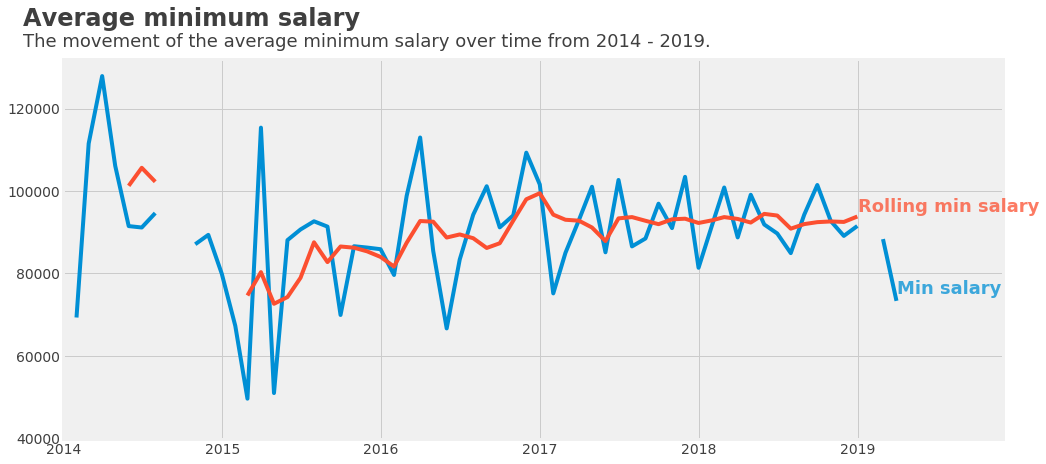

In [11]:
#Minimum salaries over time
ax, fig = plt.subplots(figsize=(15,7))

ax = plt.axes()
ax.set_xlim(left = datetime.date(2014, 1, 1), right = datetime.date(2019, 12, 1))

plt.plot(monthly_salaries["min_mean"])
plt.plot(monthly_salaries["min_mean"].rolling(window=5).mean())

plt.xticks(fontsize=14,alpha=0.75)
plt.yticks(fontsize=14,alpha=0.75)


ax.text(x=datetime.date(2019, 4, 1), y=75000,s="Min salary", weight="bold",fontsize="18",alpha=0.75,color="#008fd5")

ax.text(x=datetime.date(2019, 1, 1), y=95000,s="Rolling min salary", weight="bold",fontsize="18",alpha=0.75,color="#fc4f30")

#Title
ax.text(x=datetime.date(2013, 10, 1), y=140000,s="Average minimum salary", weight="bold",fontsize="24",alpha=0.75)
ax.text(x=datetime.date(2013, 10, 1), y=135000,s="The movement of the average minimum salary over time from 2014 - 2019.", fontsize="18",alpha=0.75)

gc.collect()

6788

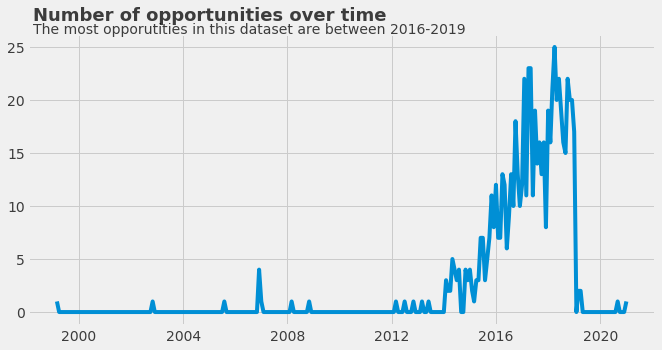

In [53]:
#Number of opportunities per year/month
ax, fig = plt.subplots(figsize=(10,5))

ax = plt.axes()
#ax.set_xlim(left = datetime.date(2014, 1, 1), right = datetime.date(2019, 12, 1))
plt.plot(monthly_salaries["count"])

plt.xticks(fontsize=14,alpha=0.75)
plt.yticks(fontsize=14,alpha=0.75)

ax.text(x=datetime.date(1998, 4, 1), y=max(monthly_salaries["count"]) + 2.5,s="Number of opportunities over time", weight="bold",fontsize="18",alpha=0.75,color="black")
ax.text(x=datetime.date(1998, 4, 1), y=max(monthly_salaries["count"]) + 1.3,s="The most opporutities in this dataset are between 2016-2019",fontsize="14",alpha=0.75,color="black")

gc.collect()

2614

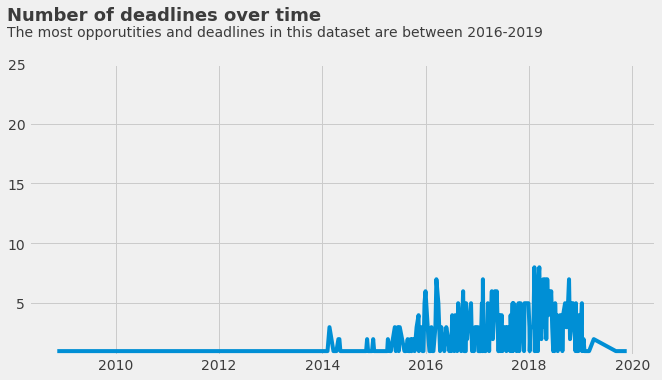

In [74]:
ax, fig = plt.subplots(figsize=(10,5))

end_date = df["application_end_date"].value_counts().sort_index()

plt.plot(end_date.index, end_date)

plt.xticks(fontsize=14,alpha=0.75)
plt.yticks(fontsize=14,alpha=0.75)

#Set the upper limit to match the above plot
plt.ylim(top = 25)

ax.text(x=0.05, y=1,s="Number of deadlines over time", weight="bold",fontsize="18",alpha=0.75,color="black")
ax.text(x=0.05, y=0.955,s="The most opporutities and deadlines in this dataset are between 2016-2019",fontsize="14",alpha=0.75,color="black")

del end_date

gc.collect()

Text(-120000, -0.8, 'The most paid position is the Cheif Port Pilot with a maximum salary of above 300k.')

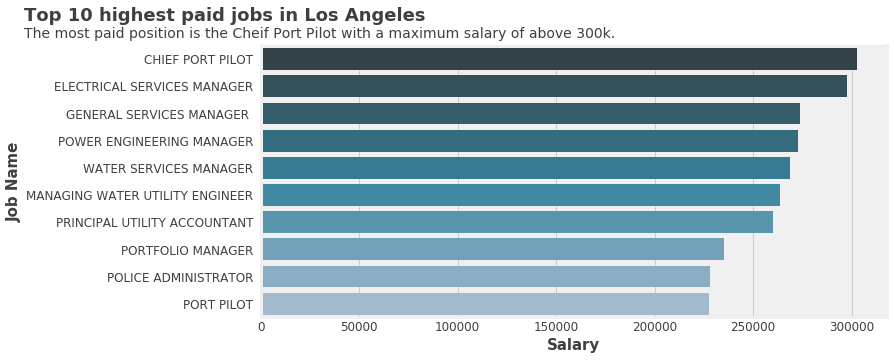

In [13]:
df_sorted = df.sort_values(by=["maximum_salary"],ascending=False)
df.reset_index(inplace=True,drop=True)

ax, fig = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=df_sorted["maximum_salary"][:10], y=df_sorted["job_name"][:10],palette="PuBuGn_d")

plt.xticks(fontsize=12,alpha=0.75)
plt.yticks(fontsize=12,alpha=0.75)

plt.xlabel("Salary",fontsize=15, alpha=0.75, weight="bold")
plt.ylabel("Job Name",fontsize=15, alpha=0.75, weight="bold")

ax.text(x=-120000, y=-1.4, s="Top 10 highest paid jobs in Los Angeles", weight="bold",fontsize=18,alpha=0.75,color="black")
ax.text(x=-120000, y=-0.8, s="The most paid position is the Cheif Port Pilot with a maximum salary of above 300k.",fontsize=14,alpha=0.75,color="black")

Text(10500, 8, 'No salary given')

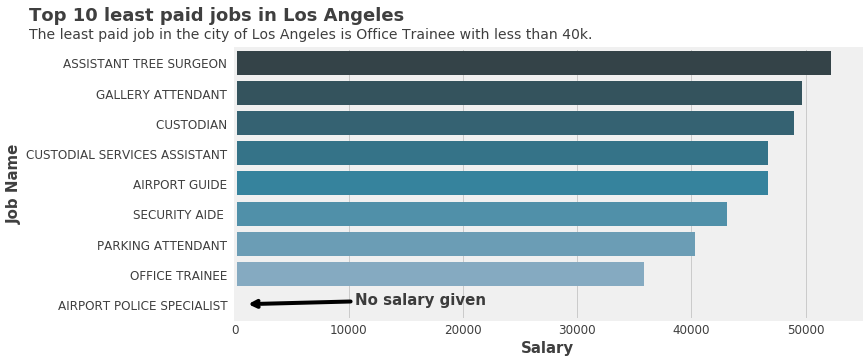

In [14]:
ax, fig = plt.subplots(figsize=(10,5))

ax = sns.barplot(x=df_sorted["maximum_salary"][-10:], y=df_sorted["job_name"][-10:],palette="PuBuGn_d")

plt.xticks(fontsize=12,alpha=0.75)
plt.yticks(fontsize=12,alpha=0.75)

plt.xlabel("Salary",fontsize=15, alpha=0.75, weight="bold")
plt.ylabel("Job Name",fontsize=15, alpha=0.75, weight="bold")

ax.text(x=-18000, y=-1.4, s="Top 10 least paid jobs in Los Angeles", weight="bold",fontsize=18,alpha=0.75,color="black")
ax.text(x=-18000, y=-0.8, s="The least paid job in the city of Los Angeles is Office Trainee with less than 40k.",fontsize=14,alpha=0.75,color="black")


#AIRPORT POLICE SPEC - indicate that no salary was given
ax.annotate("No salary given",xy=(1000,8), xytext=(10500,8),fontsize=15,weight="bold", color="black",alpha=0.75,arrowprops=dict(arrowstyle="->",color="black", linewidth=4))

In [15]:
def counter_selection(df):
    selection_counter = Counter()

    for value in df:
        
        selection_counter += Counter(value)

    return selection_counter

In [16]:
counter = counter_selection(df["selection"].dropna())
df_counter = pd.DataFrame.from_dict(counter,orient="index", columns=["count"]).reset_index()

Text(-80, -0.6, 'Most jobs require an interview as a selection task, while the second most taskis a test.')

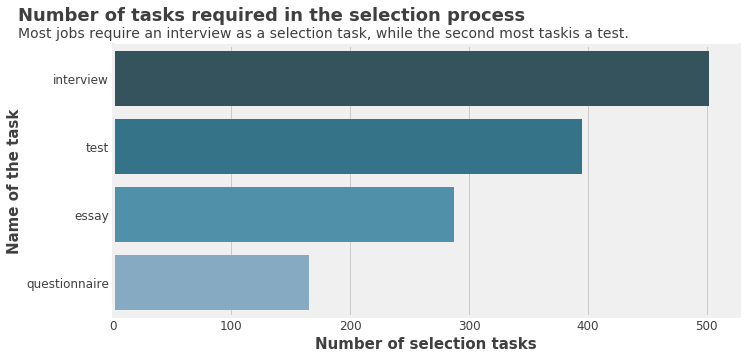

In [17]:
ax, fig = plt.subplots(figsize=(10,5))

ax = sns.barplot(x = df_counter["count"], y=df_counter["index"],palette="PuBuGn_d")

plt.xticks(fontsize=12,alpha=0.75)
plt.yticks(fontsize=12,alpha=0.75)

plt.xlabel("Number of selection tasks",fontsize=15, alpha=0.75, weight="bold")
plt.ylabel("Name of the task",fontsize=15, alpha=0.75, weight="bold")

ax.text(x=-80, y=-0.85, s="Number of tasks required in the selection process", weight="bold",fontsize=18,alpha=0.75,color="black")
ax.text(x=-80, y=-0.6, s="Most jobs require an interview as a selection task, while the second most taskis a test.",fontsize=14,alpha=0.75,color="black")


In [18]:
def data_preperation_wordc(df):
        
        """
        Cleans, tokinizes and joins the words into a string to be used for a word cloud

        """

        description = " ".join(df.dropna())
        description = re.sub('[^a-zA-Z0-9 ]+', '', description)
        word_tokens = word_tokenize(description)
        words = [word for word in word_tokens if word not in stop]
        description = " ".join(words)

        return description, words

In [19]:
description_requirements, words_requirements = data_preperation_wordc(df["requirements"])
description_duties, words_duties = data_preperation_wordc(df["job_duties"])

(0.0, 1.0, 0.0, 1.0)

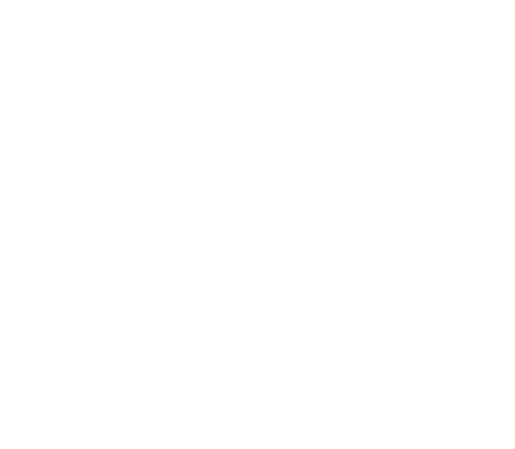

In [20]:
###### Wordcloud ######

image_mask = np.array(Image.open("images\circle.jpg"))

#word_cloud = WordCloud(background_color="white",max_words=1000,max_font_size=80, mask=image_mask, random_state=3)
#word_cloud.generate(description_requirements)

image_colours = ImageColorGenerator(image_mask)


ax, fig = plt.subplots(figsize=(8,8))
#plt.imshow(word_cloud.recolor(color_func = image_colours),interpolation="bilinear")

plt.axis("off")


(0.0, 1.0, 0.0, 1.0)

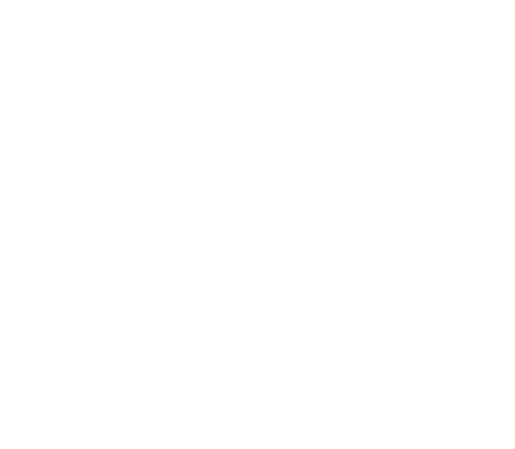

In [21]:
###### Wordcloud ######

image_mask = np.array(Image.open("images\circle.jpg"))

#word_cloud = WordCloud(background_color="white",max_words=1000,max_font_size=80, mask=image_mask, random_state=3)
#word_cloud.generate(description_duties)

image_colours = ImageColorGenerator(image_mask)


ax, fig = plt.subplots(figsize=(8,8))
#plt.imshow(word_cloud.recolor(color_func = image_colours),interpolation="bilinear")

plt.axis("off")


In [22]:
#### Job similiarity ####

vectorized = TfidfVectorizer(stop_words="english")

Tfid = vectorized.fit_transform(df_file["text_data"])

parwise_sim = Tfid*Tfid.T

In [23]:
#Creating matrix

similiarity = parwise_sim.toarray()
np.fill_diagonal(similiarity, np.nan) 

In [24]:
def find_similar_jobs(input_string,text):

    """
    Inputs a job and returns the most similar job in the dataset and its similiarity index
    """
    
    index_id = text[text == input_string].index[0]
    
    result_id = np.nanargmax(similiarity[index_id])
    result = text[result_id]

    return result, print(similiarity[index_id,result_id])

In [25]:
results = find_similar_jobs(df_file["text_data"][1],df_file["text_data"])

0.6422116873012164


In [40]:
#https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests

###ASL###
def avrg_sentence_leng(df):

    data_list = []
    for row in df:
    
        try:
            sentence = sent_tokenize(row)
            words = word_tokenize(row)
            lenght_of_sentence = len(words) / len(sentence)

        except:
            lenght_of_sentence = np.nan

        data_list.append(lenght_of_sentence)

    return data_list

In [41]:
df["ASL_duties"] = avrg_sentence_leng(df["job_duties"].astype(str))
df["ASL_req"] = avrg_sentence_leng(df["requirements"].astype(str))

In [42]:
def syllable_counter (data):

    data_list = []
    try:
        for text in data:

            counter = 0
            text = word_tokenize(text)

            for word in text:

                word = word.lower()

                for letter in ["a","e","i","o","u"]:
                    counter += word.count(letter)
                for ending in ["es","ed","e"]:
                    if word.endswith(ending):
                        counter -=1
                    else:
                        pass
                if word.endswith("le"):
                    counter +=1
            leng_text = len(text)
            counter = counter / leng_text
            data_list.append(counter)
    except:
        data_list.append(counter)

    return data_list

In [43]:
df["ASW_duties"] = syllable_counter(df["job_duties"].astype(str))
df["ASW_req"] = syllable_counter(df["requirements"].astype(str))

In [44]:
#Reading Ease score = 206.835 - (1.015 × ASL) - (84.6 × ASW)

df["Flesch_index_duties"] = 206.835 - (1.015 * df["ASL_duties"]) - (84.6 * df["ASW_duties"])
df["Flesch_index_duties"] = df["Flesch_index_duties"].apply(lambda x: max(x,0))

df["Flesch_index_req"] = 206.835 - (1.015 * df["ASL_req"]) - (84.6 * df["ASW_req"])
df["Flesch_index_req"] = df["Flesch_index_req"].apply(lambda x: max(x,0))

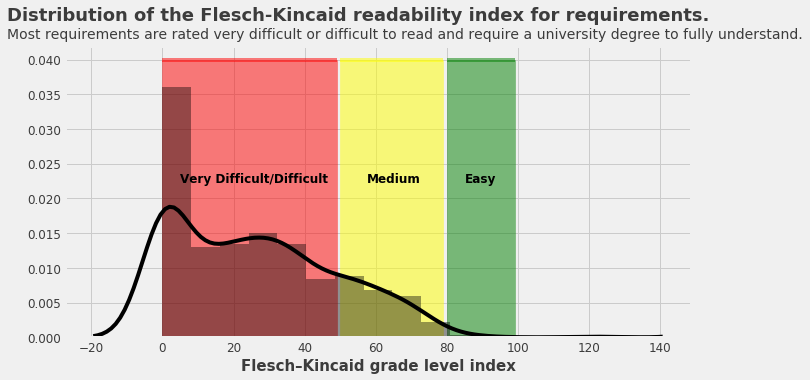

In [45]:
ax, fig = plt.subplots(figsize=(10,5))

x = sns.distplot(df["Flesch_index_req"], color="black")

plt.xticks(fontsize=12,alpha=0.75)
plt.yticks(fontsize=12,alpha=0.75)

plt.xlabel("Flesch–Kincaid grade level index",fontsize=15, alpha=0.75, weight="bold")


x = np.arange(0,50)
y = x*0+0.040
plt.plot(x,y,color="red",alpha=0.50)
plt.fill_between(x, y, color="red",alpha=0.50)
ax.text(x=0.24, y =0.5, s="Very Difficult/Difficult", weight="bold", fontsize=12)

x = np.arange(50,80)
y = x*0+0.040
plt.plot(x,y,color="yellow",alpha=0.50)
plt.fill_between(x, y, color="yellow",alpha=0.50)
ax.text(x=0.50, y =0.5, s="Medium", weight="bold", fontsize=12)


x=np.arange(80,100)
y = x*0+0.040
plt.plot(x,y,color="green",alpha=0.50)
plt.fill_between(x, y, color="green",alpha=0.50)
ax.text(x=0.635, y =0.5, s="Easy", weight="bold", fontsize=12)

ax.text(x=0, y=0.95, s="Distribution of the Flesch-Kincaid readability index for requirements.", weight="bold",fontsize=18,alpha=0.75,color="black")
ax.text(x=0, y=0.90, s="Most requirements are rated very difficult or difficult to read and require a university degree to fully understand.",fontsize=14,alpha=0.75,color="black")

gc.collect()

del x,y

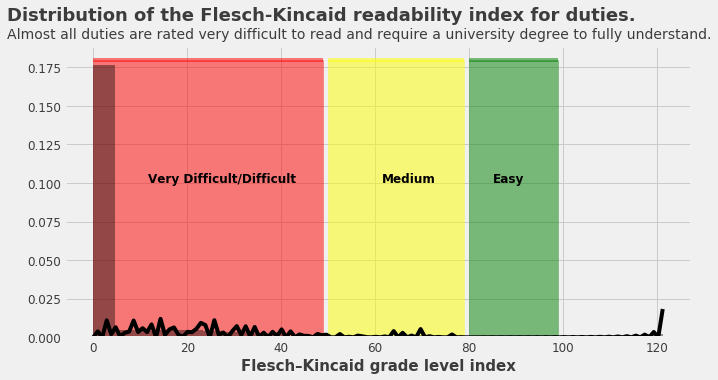

In [52]:
ax, fig = plt.subplots(figsize=(10,5))

x = sns.distplot(df["Flesch_index_duties"], color="black")

plt.xticks(fontsize=12,alpha=0.75)
plt.yticks(fontsize=12,alpha=0.75)

plt.xlabel("Flesch–Kincaid grade level index",fontsize=15, alpha=0.75, weight="bold")


x = np.arange(0,50)
y = x*0+0.180
plt.plot(x,y,color="red",alpha=0.50)
plt.fill_between(x, y, color="red",alpha=0.50)
ax.text(x=0.195, y =0.5, s="Very Difficult/Difficult", weight="bold", fontsize=12)

x = np.arange(50,80)
y = x*0+0.180
plt.plot(x,y,color="yellow",alpha=0.50)
plt.fill_between(x, y, color="yellow",alpha=0.50)
ax.text(x=0.52, y =0.5, s="Medium", weight="bold", fontsize=12)


x=np.arange(80,100)
y = x*0+0.180
plt.plot(x,y,color="green",alpha=0.50)
plt.fill_between(x, y, color="green",alpha=0.50)
ax.text(x=0.675, y =0.5, s="Easy", weight="bold", fontsize=12)

ax.text(x=0, y=0.95, s="Distribution of the Flesch-Kincaid readability index for duties.", weight="bold",fontsize=18,alpha=0.75,color="black")
ax.text(x=0, y=0.90, s="Almost all duties are rated very difficult to read and require a university degree to fully understand.",fontsize=14,alpha=0.75,color="black")

gc.collect()

del x,y